### Fernando Piani

### January 25, 2022

# Predicting Food Delivery Time Using Advanced Regression Techniques

<img src="Data/image.jpeg" width=700 height=494 />

## Introduction

Food delivery services, especially through third-party applications, saw a dramatic growth in popularity in the 2010s, fueled by the widespread of availability of smartphones and mobile broadband. More recently, the pandemic also played a significant part in accelerating this trend: according to a report by [Yelp](https://restaurants.yelp.com/articles/dine-in-vs-takeout-trends/), 60% of Americans order takeout or delivery either directly or through a third-party service at least once a week. Moreover, nearly 1/3 of Americans rely on third-party apps to order at least twice a week. 

The popularity of such applications and companies in the U.S. and around the world means that they are able to consistently amass large quantities of data on their customers, restaurant partners, drivers, and deliveries. This wealth of information makes this an industry where analytics and machine learning can provide significant competitive advantage in a number of ways. A key such use case is estimating total delivery duration - which, if done correctly, can provide benefits such as greater optimization of the courier network, as well as improved customer satisfaction.  

We will be working with a dataset found on the [Reddit dataset repository](https://reddit.com/r/datasets), which contains delivery-level information for orders placed in 2015 on a major platform across several Canadian markets. I have uploaded the raw dataset in the **Data** folder in this GitHub repo, along with a data description file.




## Business Understanding/Goal-Setting

The baseline business objective here is maximizing the accuracy of our predictions so that we can provide the customer with a reasonable and short estimated time window for arrival. In machine learning terms, we are dealing with a univariate regression task. In other words, we only have one target variable, ***total_delivery_duration_seconds***, which is continuous (i.e. can take on any numeric value). Our goal in any regression task is to minimize our error terms (i.e. the difference between predictions and actual values). At first glance, this might seem like a straightforward prediction. However, the data description file found with the original dataset provides some business context from the subject matter experts in the Canadian company which originated the data. 

The complicating factor here is that past experiments at this company have indicated that underpredicting delivery times (i.e. when orders are late relative to the ETA provided in the app) is approximately twice as detrimental to customer satisfaction as overpredicting them (i.e. when orders arrive earlier than the ETA). For a data scientist, this constraint adds several layers of complexity to our workflow beyond just the default minimization of our regression errors. We will explore these in more technical detail beginning with the **Notes on Algorithm Selection** section further down in the modeling stage.

## NOTES:  
### 1/14/2021: Need to add a few cells where we check/analyze for negative values. Can even handwave it.

## Exploratory Data Analysis

In [6]:
# Essential DS libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [7]:
%matplotlib inline

In [8]:
hist_data = pd.read_csv('https://raw.githubusercontent.com/fernandopiani/food-delivery-time-prediction/main/Data/historical_data.csv?token=GHSAT0AAAAAABP5XWMH3LN2U2UGS6X5N23UYPZLQAQ')

In [9]:
print(hist_data.shape)
hist_data.head()

(197428, 9)


,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_drivers,total_busy_drivers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


As we can see above, our target variable, which we will call *total_delivery_duration_seconds*, will need to be engineered from the *created_at* and *actual_delivery_time* timestamp columns. We will do this by first converting the latter columns into Python's Datetime format and then performing the appropriate subtraction. 

We will also create another version of the target variable converted to minutes in order to simplify our EDA visualizations - however, we will train our model only using the seconds variable.

In [10]:
# Converting timestamp columns to datetime
hist_data['created_at'] = pd.to_datetime(hist_data['created_at'], infer_datetime_format=True)
hist_data['actual_delivery_time'] = pd.to_datetime(hist_data['actual_delivery_time'], infer_datetime_format=True)
hist_data.dtypes

market_id                                              float64
created_at                                      datetime64[ns]
actual_delivery_time                            datetime64[ns]
store_id                                                 int64
subtotal                                                 int64
total_onshift_drivers                                  float64
total_busy_drivers                                     float64
total_outstanding_orders                               float64
estimated_store_to_consumer_driving_duration           float64
dtype: object

In [11]:
# Engineering target variable
hist_data['total_delivery_duration_seconds'] = (hist_data['actual_delivery_time'] - \
                                                    hist_data['created_at']).dt.total_seconds()

In [12]:
# Creating delivery minutes variable
hist_data['total_delivery_duration_minutes'] = hist_data['total_delivery_duration_seconds']/60
hist_data.dtypes

market_id                                              float64
created_at                                      datetime64[ns]
actual_delivery_time                            datetime64[ns]
store_id                                                 int64
subtotal                                                 int64
total_onshift_drivers                                  float64
total_busy_drivers                                     float64
total_outstanding_orders                               float64
estimated_store_to_consumer_driving_duration           float64
total_delivery_duration_seconds                        float64
total_delivery_duration_minutes                        float64
dtype: object

In [13]:
print(hist_data.shape)
hist_data.head()

(197428, 11)


,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_drivers,total_busy_drivers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds,total_delivery_duration_minutes
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0,3779.0,62.983333
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0,4024.0,67.066667
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0,1781.0,29.683333
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0,3075.0,51.250000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0,2390.0,39.833333


In [14]:
hist_data.describe()

,market_id,store_id,subtotal,total_onshift_drivers,total_busy_drivers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds,total_delivery_duration_minutes
count,196441.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,196902.000000,1.974210e+05,197421.000000
mean,2.978706,3530.510272,2682.331402,44.808093,41.739747,58.050065,545.358935,2.908257e+03,48.470956
std,1.524867,2053.496711,1823.093688,34.526783,32.145733,52.661830,219.352902,1.922961e+04,320.493482
min,1.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,1.010000e+02,1.683333
25%,2.000000,1686.000000,1400.000000,17.000000,15.000000,17.000000,382.000000,2.104000e+03,35.066667
50%,3.000000,3592.000000,2200.000000,37.000000,34.000000,41.000000,544.000000,2.660000e+03,44.333333
75%,4.000000,5299.000000,3395.000000,65.000000,62.000000,85.000000,702.000000,3.381000e+03,56.350000
max,6.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000,8.516859e+06,141947.650000


In [15]:
hist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 11 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   subtotal                                      197428 non-null  int64         
 5   total_onshift_drivers                         181166 non-null  float64       
 6   total_busy_drivers                            181166 non-null  float64       
 7   total_outstanding_orders                      181166 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  196902 n

In [16]:
# Percentage of missing values in each column
print(hist_data.isna().sum()/len(hist_data))

market_id                                       0.004999
created_at                                      0.000000
actual_delivery_time                            0.000035
store_id                                        0.000000
subtotal                                        0.000000
total_onshift_drivers                           0.082369
total_busy_drivers                              0.082369
total_outstanding_orders                        0.082369
estimated_store_to_consumer_driving_duration    0.002664
total_delivery_duration_seconds                 0.000035
total_delivery_duration_minutes                 0.000035
dtype: float64


In [17]:
# Number of unique values per column
hist_data.nunique()

market_id                                            6
created_at                                      180985
actual_delivery_time                            178110
store_id                                          6743
subtotal                                          8368
total_onshift_drivers                              172
total_busy_drivers                                 159
total_outstanding_orders                           281
estimated_store_to_consumer_driving_duration      1336
total_delivery_duration_seconds                   7134
total_delivery_duration_minutes                   7134
dtype: int64

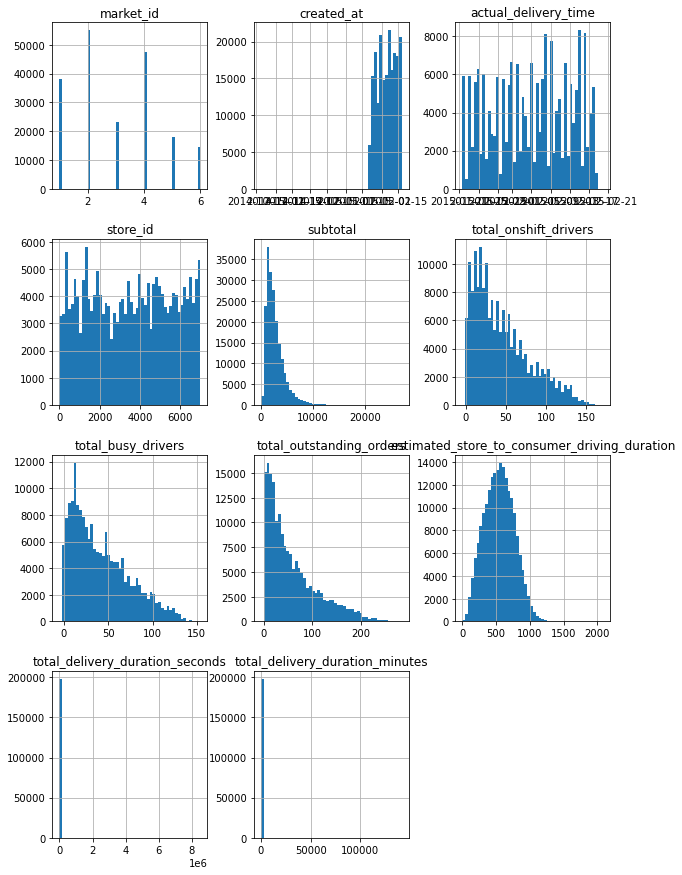

In [18]:
# Univariate distributions of all numerical columns
_ = hist_data.hist(bins=50, figsize=(10,15))

Since the default matplotlib hist function did not produce interesting visualizations for our target variable, we will create our own using Seaborn.

[Text(0.5, 0, 'Actual delivery duration (minutes)'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Delivery Duration Histogram')]

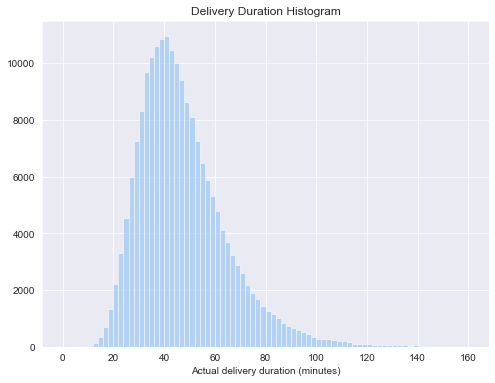

In [19]:
# Visualization distribution of delivery duration minutes
sns.set_style('darkgrid')
sns.set_palette('pastel')
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.histplot(x='total_delivery_duration_minutes', data=hist_data, bins=[x * 2 for x in range(0,81)], kde=False)
ax.set(xlabel='Actual delivery duration (minutes)', ylabel='', title='Delivery Duration Histogram')

As we can see above, this a long-tailed distribution. While we know from the *describe* function we called a few cells preceding that 75% of all deliveries are faster than 56 minutes, we can see that there are a fair amount of deliveries exceeding this number. These long-tail events might make our prediction task more difficult, but they are part of the business reality of food deliveries. This means that unlike outliers, we cannot delete them.

We will now investigate the presence of actual outliers. For this, we will use the interquartile range (IQR) method for detecting outliers and classify as outliers any observations below 1.5 * IQR * Q1 and above 1.5 * IQR * Q3.

In [20]:
q25 = hist_data['total_delivery_duration_seconds'].quantile(0.25)
q75 = hist_data['total_delivery_duration_seconds'].quantile(0.75)
iqr = q75 - q25

In [21]:
# Printing outlier thresholds according to IQR method
print(q25 - 1.5*iqr, q75 + 1.5*iqr)

188.5 5296.5


In [22]:
# Calculating number of outliers
hist_data['is_outlier'] = False
hist_data.loc[hist_data['total_delivery_duration_seconds'] > (q75+1.5*iqr), 'is_outlier'] = True
hist_data.loc[hist_data['total_delivery_duration_seconds'] < (q25-1.5*iqr), 'is_outlier'] = True
outlier_count = len(hist_data[hist_data['is_outlier'] == True])
outlier_pct = len(hist_data[hist_data['is_outlier'] == True])/len(hist_data)
print(f'There are {outlier_count} outliers, corresponding to {round(outlier_pct*100, 3)}% of overall data.')

There are 6278 outliers, corresponding to 3.18% of overall data.


So, through the IQR method we have found that deliveries shorter than ~3 minutes and longer than ~89 minutes are outliers. These only account for a small portion of our data. Therefore, we can go ahead and delete them without any major information loss concerns. Our models will be trained on realistic delivery time windows we might expect to see on a daily basis, while continuing to be robust to long-tail events.

In [23]:
# Deleting outliers
hist_data = hist_data[hist_data['is_outlier'] == False]
hist_data.drop(columns=['is_outlier', 'total_delivery_duration_minutes'], inplace=True)


In [24]:
print(hist_data.shape)
hist_data.head()

(191150, 10)


,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_drivers,total_busy_drivers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0,2390.0


Finally, let's use the missingno library to detect whether there is any selection bias in our missing values.

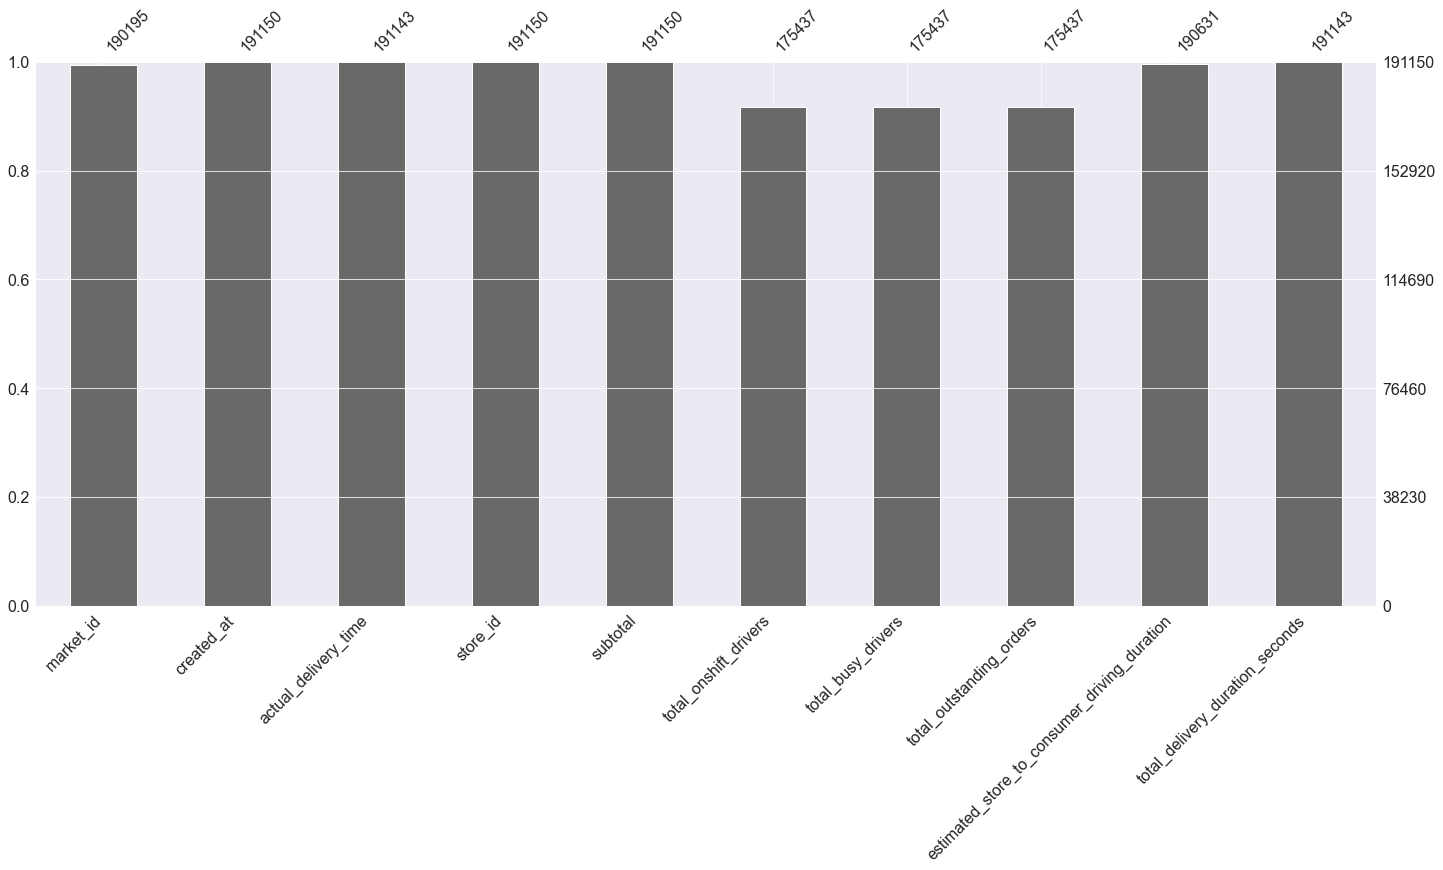

In [25]:
import missingno as msno
_ = msno.bar(hist_data)

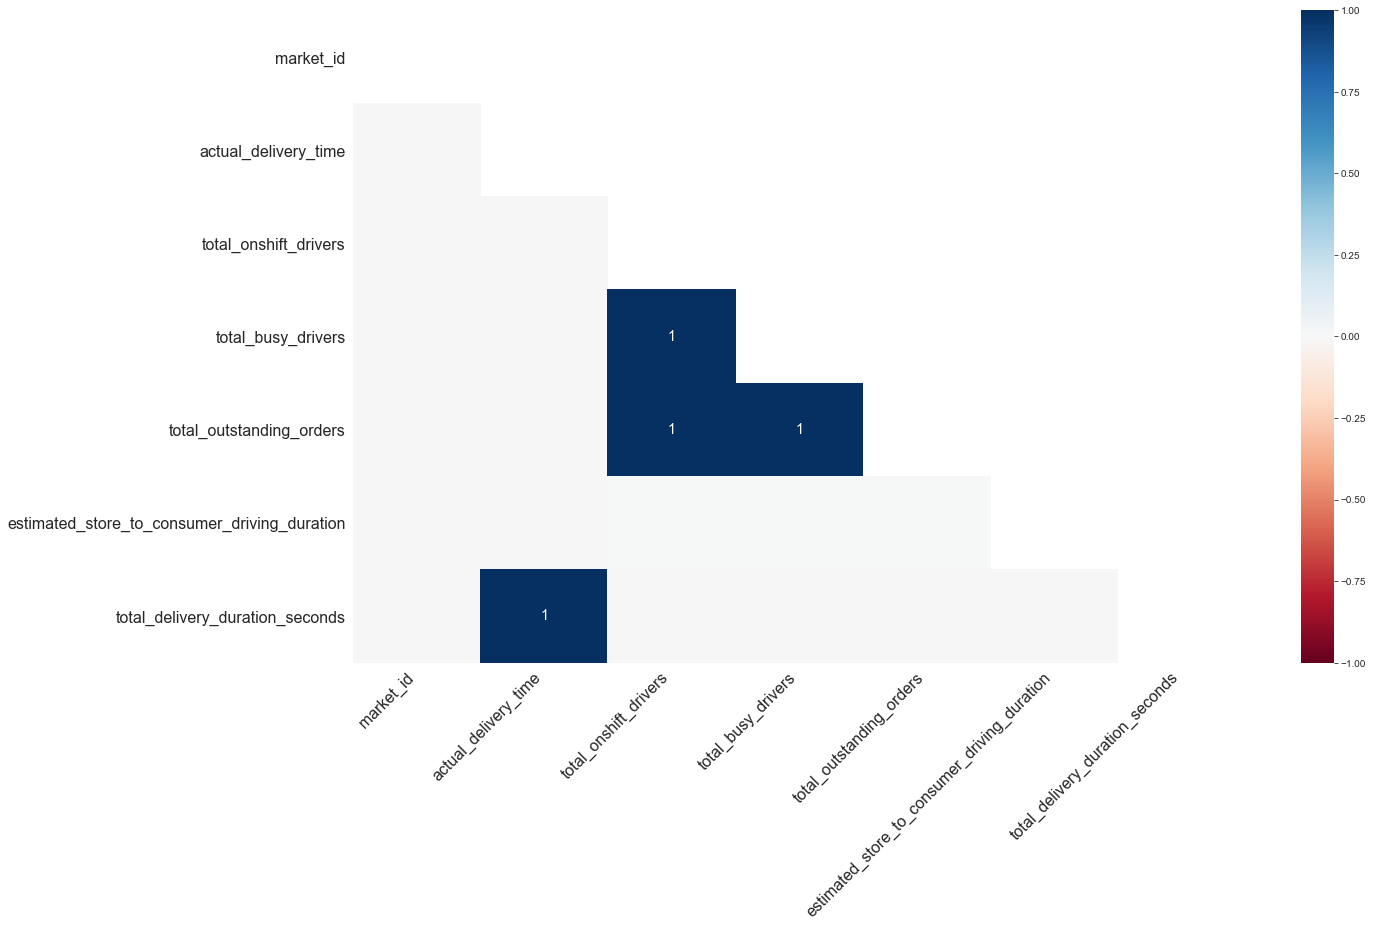

In [26]:
_ = msno.heatmap(hist_data)

From the visualizations above, there is no missingness correlation between the columns, so we can reasonably assume that there is not selection bias when it comes to missing values. We will delete the 7 rows where the target variable is missing for now. Later, we will impute missing values for the features with 0s as part of our pipeline.

In [27]:
hist_data['total_delivery_duration_seconds'].isna().sum()

7

In [28]:
hist_data.dropna(subset=['total_delivery_duration_seconds'], inplace=True)

In [29]:
hist_data.isna().sum()

market_id                                         955
created_at                                          0
actual_delivery_time                                0
store_id                                            0
subtotal                                            0
total_onshift_drivers                           15713
total_busy_drivers                              15713
total_outstanding_orders                        15713
estimated_store_to_consumer_driving_duration      519
total_delivery_duration_seconds                     0
dtype: int64

At this stage, we will split our data into train and test sets. We will then perform the rest of our EDA using only the train set in order to avoid any data snooping bias.



In [30]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(hist_data, test_size=0.2, random_state=42)

Our last 2 EDA steps, using only the train set, will be to examine feature correlations and attempt to build features that are more highly correlated with the target variable.

In [31]:
# Copying train set for further EDA
deliveries = train_set.copy()

In [32]:
# Examining correlations
corr_matrix = deliveries.corr()
corr_matrix['total_delivery_duration_seconds'].sort_values(ascending=False)

total_delivery_duration_seconds                 1.000000
estimated_store_to_consumer_driving_duration    0.256387
subtotal                                        0.235084
total_outstanding_orders                        0.225303
total_busy_drivers                              0.137001
total_onshift_drivers                           0.116904
store_id                                       -0.008233
market_id                                      -0.035966
Name: total_delivery_duration_seconds, dtype: float64

### Feature engineering  

Let's try to create other measures of marketplace health - *available_drivers*, *outstanding_orders_per_dasher* and *outstanding_orders_per_avail_driver* and see how our correlations look afterward.

In [34]:
deliveries['avail_drivers'] = deliveries['total_onshift_drivers'] - deliveries['total_busy_drivers']
deliveries['outstanding_orders_per_driver'] = deliveries['total_outstanding_orders']/deliveries['total_onshift_drivers']
deliveries['outstanding_orders_per_avail_driver'] = deliveries['total_outstanding_orders']/deliveries['avail_drivers']

In [35]:
corr_matrix = deliveries.corr()
corr_matrix['total_delivery_duration_seconds'].sort_values(ascending=False)

total_delivery_duration_seconds                 1.000000
outstanding_orders_per_driver                   0.334395
estimated_store_to_consumer_driving_duration    0.256387
subtotal                                        0.235084
total_outstanding_orders                        0.225303
total_busy_drivers                              0.137001
total_onshift_drivers                           0.116904
outstanding_orders_per_avail_driver             0.060141
store_id                                       -0.008233
avail_drivers                                  -0.031456
market_id                                      -0.035966
Name: total_delivery_duration_seconds, dtype: float64

Great! Our new feature, *outstanding_orders_per_driver* actually has the highest correlation with the target variable. Lastly, before deciding what features to keep, let's examine all correlations and remove any correlated features.

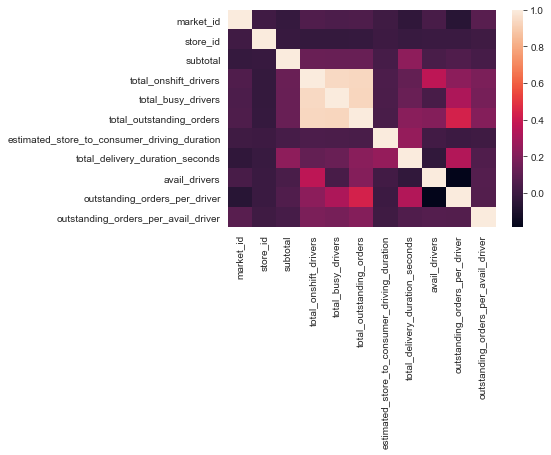

In [36]:
_ = sns.heatmap(data = corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

Based on the data above, we will drop the original column *total_onshift_drivers*, since it is highly correlated with two other features which themselves have a higher correlation with the target variable.  

We will also not include our two other engineered features, *avail_drivers* and *outstanding_orders_per_avail_driver*, in the final dataset for modeling. This is due to their low explanatory power and in order to simplify our model and its computations.

In [38]:
deliveries.drop(columns=['total_onshift_drivers', 'avail_drivers', 'outstanding_orders_per_avail_driver'], inplace=True)

In [39]:
deliveries.shape

(152914, 10)

## Data Preparation

We will now perform the actual transformations needed to feed our data into machine learning algorithms. This will include many of the steps we already performed above, including engineering the target variable and additional tweaks to the raw data, such as making the necessary type conversions, etc.  

However, instead of transforming this data manually, we will follow industry best practices and create tranformation Pipelines so that we can easily perform the same operations on new real-world data when needed.  

In addition to out-of-the-box Scikit-learn transformers for simpler and more general operations, such as scaling and imputation, we will need transformers that will handle the specific intricacies of this dataset. For example, we need a transformer that will engineer the *total_delivery_duration_seconds* column from the original date columns. For this, we will create new custom transformer objects to insert in our Scikit-learn pipeline.  


### Custom Transformer Creation

Our first Custom Transformer will engineer our labels, i.e. delivery time. It will also remove outliers - allowing the user to set a specific upper threshold for them or the default 1.5 * IQR * Q3 - and missing values.

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer to extract labels (delivery time) from new data
class DeliveryTimeCalculator(BaseEstimator, TransformerMixin):

	def __init__(self, upper_outlier_seconds = None):
		self.fixed_threshold = upper_outlier_seconds

	def fit(self, X, y=None):
		return self

	def transform(self, X):
		assert isinstance(X, (pd.Series, pd.DataFrame))
		X = X.copy()
		X['created_at'] = pd.to_datetime(X['created_at'], infer_datetime_format=True)
		X['actual_delivery_time'] = pd.to_datetime(X['actual_delivery_time'], infer_datetime_format=True)
		X['total_delivery_duration_seconds'] = (X['actual_delivery_time'] - \
													X['created_at']).dt.total_seconds()

		q25 = X['total_delivery_duration_seconds'].quantile(0.25)
		q75 = X['total_delivery_duration_seconds'].quantile(0.75)
	
		iqr = q75 - q25

		lo_threshold = q25 - 1.5 * iqr

    # If upper threshold not specified, just use 1.5*IQR*Q3
		if self.fixed_threshold is None:
			hi_threshold = q75 + 1.5 * iqr
		else:
			hi_threshold = self.fixed_threshold


		X['is_outlier'] = False
		X.loc[X['total_delivery_duration_seconds'] > hi_threshold, 'is_outlier'] = True
		X.loc[X['total_delivery_duration_seconds'] < lo_threshold, 'is_outlier'] = True
		X = X[X['is_outlier'] == False]
		X = X.drop('is_outlier', axis=1)
		X = X.dropna(subset=['total_delivery_duration_seconds'])

		return X

Our second and final custom transformer will implement the transformations we made to the features during EDA. The most important step here is engineering the feature *outstanding_orders_per_driver*, which we found to have the highest correlation with the target variable, and removing the original columm *total_onshift_driver* for the purposes of model parsimony. 

This transformer will also drop the irrelevant date features as well as the *market_id* and *store_id* columns, which are system-generated keys with little to no explanatory power. Lastly, it will also replace any negative/infinite values with NaNs for imputation later on in the pipeline.

In [41]:
# Custom transformer to process features
class DeliveryFeatureProcessor(BaseEstimator, TransformerMixin):

	def __init__(self, add_outstanding_orders_per_dasher = True):
		self.add_outstanding_orders_per_dasher = add_outstanding_orders_per_dasher

	def fit(self, X, y=None):
		return self

	def transform(self, X):
		assert isinstance(X, (pd.Series, pd.DataFrame))
		X = X.copy()

		# Dropping irrelevant features and target variable
		X.drop(columns=['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'total_delivery_duration_seconds'], inplace=True)

		if self.add_outstanding_orders_per_dasher:
			X['outstanding_orders_per_driver'] = X['total_outstanding_orders']/X['total_onshift_drivers']
			X.drop(columns=['total_onshift_drivers'], inplace=True)
	 
	 	# Printing feature names for final analysis
		print(X.columns)

		# Replacing all negative and infinite values of these features with np.nan, to be 
		# processed with a built-in imputer later on in the pipeline	
		X[X < 0] = np.nan
		X[X == np.inf] = np.nan

		return X

### Pipeline creation


Now, we can go ahead and create the pipeline, which will use our custom *DeliveryFeatureProcessor* followed by Scikit-learn's built-in *SimpleImputer* (to replace NaNs with zeroes) and *StandardScaler* to standardize feature values.

In [42]:
# Sklearn built-in transformers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [43]:
pipeline = Pipeline([('df_processor', DeliveryFeatureProcessor()),  \
                     ('imputer', SimpleImputer(strategy='constant', fill_value=0)), ('scaler', StandardScaler())])

The last step before modeling, therefore, is to actually transform the data. We will apply our target variable extractor on the full dataset, then separate out the target feature array, and finally apply the transformation pipeline to the features.

In [44]:
# Resetting raw data and splitting into train/test sets
hist_data = pd.read_csv('https://raw.githubusercontent.com/fernandopiani/food-delivery-time-prediction/main/Data/historical_data.csv?token=GHSAT0AAAAAABP5XWMH3LN2U2UGS6X5N23UYPZLQAQ')
train_set, test_set = train_test_split(hist_data, test_size=0.2, random_state=42)

In [45]:
# Extracting target variable
deliveries = DeliveryTimeCalculator().fit_transform(train_set)
delivery_labels = deliveries['total_delivery_duration_seconds'].copy().to_numpy()

In [46]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152926 entries, 178523 to 121958
Data columns (total 10 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     152160 non-null  float64       
 1   created_at                                    152926 non-null  datetime64[ns]
 2   actual_delivery_time                          152926 non-null  datetime64[ns]
 3   store_id                                      152926 non-null  int64         
 4   subtotal                                      152926 non-null  int64         
 5   total_onshift_drivers                         140334 non-null  float64       
 6   total_busy_drivers                            140334 non-null  float64       
 7   total_outstanding_orders                      140334 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  152

In [47]:
deliveries.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_drivers,total_busy_drivers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
178523,3.0,2015-02-10 02:25:28,2015-02-10 03:09:01,1659,1298,0.0,0.0,0.0,821.0,2613.0
89414,4.0,2015-01-23 04:23:13,2015-01-23 05:01:12,3748,1690,78.0,64.0,75.0,406.0,2279.0
94190,1.0,2015-01-24 03:33:32,2015-01-24 04:03:35,6750,3300,63.0,66.0,90.0,296.0,1803.0
136117,5.0,2015-02-17 00:25:38,2015-02-17 01:14:22,6456,3029,23.0,15.0,15.0,773.0,2924.0
53337,4.0,2015-01-26 01:19:16,2015-01-26 02:24:02,6889,3390,71.0,98.0,91.0,758.0,3886.0


In [48]:
# Transforming features for modeling
deliveries_transformed = pipeline.fit_transform(deliveries)

Index(['subtotal', 'total_busy_drivers', 'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'outstanding_orders_per_driver'],
      dtype='object')


# Modeling

## Notes on Algorithm Selection

We will now proceed to the modeling and evaluation stage. Model choice is, of course, a critical step in any machine learning task. What is arguably even more critical, however, is making sure your model selection decisions are informed by the original problem at hand and the specific goals set by the business stakeholders.  

As mentioned in the Introduction, in our case the stakeholders and subject matter experts have informed us that order lateness, i.e. underprediction, is approximately twice as harmful to customer satistfaction (and therefore to the business) as overpredictions.  

For a data scientist, this means we need to adjust our loss function. As a reminder, loss/cost functions model the "price paid" for inaccurate predictions - machine learning algorithms seek to minimize this number when trained. This function is usually symmetric, meaning that a positive residual (i.e. underprediction) and a negative one (i.e. overprediction) with the same absolute value, e.g. +7 and -7, are weighed equally during optimization. For our case, however, we know that underpredictions should be weighed twice more.

Unfortunately, many popular ML libraries only have symmetric loss functions built-in and make it quite difficult to create custom functions (or, in some cases, the algorithm's structure itself is not conducive to such tweaks), as we'll need to do in order to make ours asymmetric. This limits the number of models and libraries we can use in this project.

Fortunately, the powerful and efficient [LightGBM](https://lightgbm.readthedocs.io/en/latest/) gradient boosting library created by Microsoft does enable simple incorporation of custom loss functions. Moreover, the high-level deep learning API [Keras](https://keras.io/api/) also provides this functionality. For these reasons, we will compare and contrast the performance of these two libraries and their algorithms (i.e. gradient boosting vs. neural networks) on this dataset.

### LightGBM approach

Let us first test out LightGBM's performance on this dataset, including evaluation after some light hyperparameter tuning, before moving on to Keras.  

Before we begin, we will create our custom loss function to weigh underpredictions twice as much as overpredictions.  

**Note**: each loss function created in this project follows the same asymmetric logic of weighing underpredictions more; however, their syntax and implementation may differ due to the requirements of each individual API we are working with. For more detail, please see the general LightGBM and Keras API docs linked above as well as this documentation for Scikit-learn's [*make_scorer*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) wrapper.

#### Custom loss functions for LightGBM and Scikit-learn

In [ ]:
# Custom asymmetric loss function for LightGBM
def overpred_skewed_objective(y, pred):
    residual = (y - pred).astype('float')
    grad = np.where(residual < 0, -2*residual, -2*2*residual)
    hess = np.where(residual < 0, 2, 2.0*2)
    return grad, hess

In [ ]:
# Custom asymmetric loss function for sklearn
def overpred_skewed_loss(y, pred):
	overpred = np.mean(np.maximum(pred - y, 0)**2)
	underpred = np.mean(np.maximum(y - pred, 0)**2)
	loss =  (4 * underpred)/3 + (2 * overpred)/3

	return loss

In [ ]:
# Importing and using sklearn wrapper to make this into a scoring function for use w/ cross_val_score
from sklearn.metrics import make_scorer
asym_score = make_scorer(overpred_skewed_loss, greater_is_better=False)

We will now create a regressor scoring function using cross-validation to measure performance in our custom loss terms.

In [ ]:
def cv_regressor_custom_metrics(model, X, y, cv):
	"""Computes mean and std. dev. of cross-validated RMSE based on user-defined number of folds."""

	start = time.time()

	# Compute cross-validated scores
	custom_mse = cross_val_score(model, X, y, cv=cv, scoring=asym_score, n_jobs=-1)
	custom_rmse = np.sqrt(-custom_mse)

	# Print list of scores
	print(f"Mean \"Custom\" loss/asymmetric MSE computed using {cv}-fold cross-validation: {-custom_mse.mean()}")
	print(f"Mean \"Custom\" RMSE  computed using {cv}-fold cross-validation: {custom_rmse.mean()}")
	print(f"\"Custom\" RMSE std. deviation computed using {cv}-fold cross-validation: {custom_rmse.std()}")
	print(f"Computation time: {time.time() - start}")

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import time

In [ ]:
# LightGBM using custom asymmetrical objective function
custom_lgbm = LGBMRegressor(random_state=21, objective=overpred_skewed_objective)

# LightGBM using default non-asymmetrical objective function
default_lgbm = LGBMRegressor(random_state=21)

# RandomForestRegressor for baseline comparison
forest_reg = RandomForestRegressor(n_estimators=50, random_state=21)

With our models and scoring function ready, we can commence performance evaluation.

In [ ]:
models = [custom_lgbm, default_lgbm, forest_reg]

In [ ]:
for model in models:
	cv_regressor_custom_metrics(model, deliveries_transformed, delivery_labels, 5)

Mean "Custom" loss/asymmetric MSE computed using 5-fold cross-validation: 573339.1391497519
Mean "Custom" RMSE  computed using 5-fold cross-validation: 757.1801516337952
"Custom" RMSE std. deviation computed using 5-fold cross-validation: 4.16618789481541
Computation time: 5.5167930126190186
Mean "Custom" loss/asymmetric MSE computed using 5-fold cross-validation: 616345.9434416107
Mean "Custom" RMSE  computed using 5-fold cross-validation: 785.066735166641
"Custom" RMSE std. deviation computed using 5-fold cross-validation: 4.020544291727142
Computation time: 3.297861337661743


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean "Custom" loss/asymmetric MSE computed using 5-fold cross-validation: 660127.6777033092
Mean "Custom" RMSE  computed using 5-fold cross-validation: 812.4749123061016
"Custom" RMSE std. deviation computed using 5-fold cross-validation: 3.4920733814932565
Computation time: 100.87364387512207


As we can see above, our custom trained LightGBM did score higher according to our custom function weighing underpredictions twice as much as overpredictions. Additionally, both custom and non-custom LightGBM models significantly outperformed the RandomForestRegressor in performance and computation time, as expected.  

Next, let us compare the kernel density plots of both LightGBM models to confirm our distributions are indeed different - in other words, that our custom model does show fewer positive residuals (underpredictions) than the standard model.

In [ ]:
# Initializing dataframe w/ predictions
residuals_df = pd.DataFrame({'Custom LGBM':[], 'Default LGBM':[]})

In [ ]:
# Making cross-validated predictions with both LGBM models and using these to fill the residuals dataframe
residuals_df['Custom LGBM'] = delivery_labels - cross_val_predict(custom_lgbm, deliveries_transformed, delivery_labels, cv=5, n_jobs=-1)
residuals_df['Default LGBM'] = delivery_labels - cross_val_predict(default_lgbm, deliveries_transformed, delivery_labels, cv=5, n_jobs=-1)

In [ ]:
print(residuals_df.head())

   Custom LGBM  Default LGBM
0  -514.692604   -287.205348
1    96.171709    267.110778
2 -1177.905228   -963.021709
3    -9.488951    226.472109
4   811.892095   1016.603142


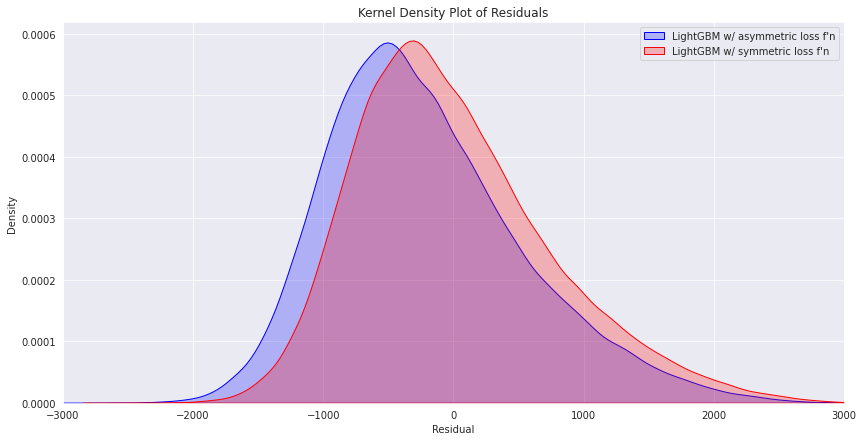

In [ ]:
# Plotting
sns.set_style('darkgrid')
sns.set_palette('pastel')
fig, ax = plt.subplots(figsize=(14,7))
ax = sns.kdeplot(x='Custom LGBM', fill=True, legend=True, color='blue',data=residuals_df)
ax = sns.kdeplot(x='Default LGBM', fill=True,legend=True, color='red',data=residuals_df)
ax.set(title='Kernel Density Plot of Residuals', xlabel='Residual', xlim=(-3000,3000))
ax.legend(labels=["LightGBM w/ asymmetric loss f'n","LightGBM w/ symmetric loss f'n"])

Therefore, we have shown above that our custom asymmetric loss function is successful in diminishing the number of underpredictions. As an added investigative measure, let us also calculate the symmetric MSE we achieved with our model.

In [ ]:
def cv_regressor_rmse(model, X, y, cv):
	"""Computes mean and std. dev. of cross-validated RMSE based on user-defined number of folds."""

	start = time.time()

	# Compute cross-validated  scores
	mse = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
	rmse = np.sqrt(-mse)

	# Print list of scores
	print(f"Mean RMSE  computed using {cv}-fold cross-validation: {rmse.mean()}")
	print(f"RMSE std. deviation computed using {cv}-fold cross-validation: {rmse.std()}")
	print(f"Computation time: {time.time() - start}")

In [ ]:
cv_regressor_rmse(custom_lgbm, deliveries_transformed, delivery_labels, 5)

Mean RMSE  computed using 5-fold cross-validation: 790.9485941638314
RMSE std. deviation computed using 5-fold cross-validation: 3.5754292754481916
Computation time: 6.278617858886719


The symmetric MSE of 790 seconds, or 13 min 48s, is slightly higher than the asymmetric MSE of 757 seconds. Before moving on to neural networks, let us now see if we can improve upon this performance with some light hyperparameter tuning. For this step, we will have to create a custom random search function to evaluate the performance of our LightGBM across a subset of its hyperparameter space. 

#### Custom random search function for LightGBM

In [ ]:
def lgbm_reg_random_search(X, y, n_iter=10, random_state=42, cv=5):
    """Computes cross-validation random search for a LightGBM regressor."""

    # Computation time
    start = time.time()

    # Dictionary to hold results
    cv_scores = {'Iteration':[], 'Parameters': [], 'Mean loss':[]}

    for i in range(n_iter):
        # Initialize random parameters
        params  = {}
        params['num_leaves'] = np.random.randint(20, 300)
        params['min_data'] = np.random.randint(10, 100)
        params['max_depth'] = np.random.randint(5, 200)

        cv_scores['Iteration'].append(i)
        cv_scores['Parameters'].append(params)

        model = LGBMRegressor(objective=overpred_skewed_objective, **params)
        
        # Compute cross-validated scores
        custom_loss = cross_val_score(model, X, y, cv=cv, scoring=asym_score, n_jobs=-1)
        cv_scores['Mean loss'].append(np.mean(-custom_loss))

    # Create sorted dataframe by lowest loss and return
    cv_scores = pd.DataFrame(cv_scores)
    cv_scores.sort_values(by='Mean loss', inplace=True)
    return cv_scores

In [ ]:
cv_scores = lgbm_reg_random_search(deliveries_transformed, delivery_labels, n_iter=50)

In [ ]:
print(cv_scores.head())
print(cv_scores['Parameters'].iloc[0])

    Iteration                                         Parameters      Mean loss
32         32  {'num_leaves': 53, 'min_data': 49, 'max_depth'...  572463.286174
40         40  {'num_leaves': 67, 'min_data': 79, 'max_depth'...  572629.667400
26         26  {'num_leaves': 77, 'min_data': 37, 'max_depth'...  572639.308673
42         42  {'num_leaves': 64, 'min_data': 54, 'max_depth'...  572644.626061
20         20  {'num_leaves': 43, 'min_data': 53, 'max_depth'...  572701.283120
{'num_leaves': 53, 'min_data': 49, 'max_depth': 159}


In [ ]:
# Initializing best model instance
best_params = cv_scores['Parameters'].iloc[0]
final_lgbm = LGBMRegressor(objective=overpred_skewed_objective, **best_params)

Therefore, the best mean loss score obtained during this random search was 572463, meaning an asymmetric MSE of 756, a very slight improvement over the default hyperparameters.  

Our last step in the modeling stage will be to compare this performance with our best-performing neural network (including some light hyperparameter tuning) in order to select the winner.

## Keras implementation

In [ ]:
# Keras libraries
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

#### Custom loss function for Keras

In [ ]:
def overpred_skewed_loss(y_true, y_pred):
	"""Custom asymmetrical loss function designed to weigh underpredictions twice as much as
		overpredictions. """

	# Getting overpredictions and obtaining their avg. SSE
	overpred  = K.mean(K.maximum(y_pred - y_true, 0)**2)
	# Getting underpredictions and obtaining their avg. SSE
	underpred  = K.mean(K.maximum(y_true - y_pred, 0)**2)
	# Weighing undepredictions twice as much as overpredictions, while keeping units same
	loss =  (4 * underpred)/3 + (2 * overpred)/3
	
	return loss

In [ ]:
deliveries_transformed.shape[1]

5

#### Notes on Neural Network archictecture selection

We will us first create a simple Sequential network with 3 hidden layers to obtain a baseline Keras performance. Since we are dealing with a simple univariate regression problem with only 5 features, simpler architectures such as this one are more than enough to generate accurate predictions.

A common pitfall when training neural networks for regression is the exploding gradient problem - meaning that the derivatives of the loss function can start growing exponentially, causing the gradient descent algorithm to diverge (i.e. an optimal solution is not found). In order to prevent this issue, we can implement gradient clipping, or limiting them to a certain threshold.

Additionally, we will use Scaled ELU, or SelU, as the activation function in lieu of the more prevalent RelU. Recent literature indicates that this activation function always either outperforms or shows equal performance to RelU. This function is also a useful tool in combating the exploding/vanishing gradient problems since it may cause networks to self-normalize (i.e. layer outputs preserve a mean of 0 and standard deviation of 1) if certain conditions are met.

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(5,)))
model.add(Dense(30, activation='selu', kernel_initializer='lecun_normal'))
model.add(Dense(30, activation='selu', kernel_initializer='lecun_normal'))
model.add(Dense(30, activation='selu', kernel_initializer='lecun_normal'))
model.add(Dense(1))
# Clipping gradients to a threshold of 2
opt = SGD(learning_rate=0.01, momentum=0.9, clipnorm=2)

In [ ]:
model.compile(optimizer=opt, loss = overpred_skewed_loss, metrics=['mean_squared_error'])

In [ ]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=4, restore_best_weights=True)

In [ ]:
model.fit(deliveries_transformed, delivery_labels, epochs=30, validation_split=0.25, callbacks=[early_stopping_monitor])

Epoch 1/30
3585/3585 [==============================] - 14s 3ms/step - loss: 735714.7500 - mean_squared_error: 762651.7500 - val_loss: 609305.1250 - val_mean_squared_error: 633057.3125
Epoch 2/30
3585/3585 [==============================] - 13s 4ms/step - loss: 604862.3750 - mean_squared_error: 659666.0625 - val_loss: 604839.6250 - val_mean_squared_error: 698553.0000
Epoch 3/30
3585/3585 [==============================] - 13s 4ms/step - loss: 599791.5625 - mean_squared_error: 651562.3125 - val_loss: 593282.8750 - val_mean_squared_error: 657139.1250
Epoch 4/30
3585/3585 [==============================] - 13s 3ms/step - loss: 602044.8125 - mean_squared_error: 655180.5000 - val_loss: 597265.0000 - val_mean_squared_error: 658071.8750
Epoch 5/30
3585/3585 [==============================] - 13s 4ms/step - loss: 599585.1250 - mean_squared_error: 651701.0625 - val_loss: 605967.4375 - val_mean_squared_error: 629363.5625
Epoch 6/30
3585/3585 [==============================] - 13s 4ms/step - loss

We are still significantly underperfoming LightGBM - this network's best performance resulted in an asymmetric loss of  596674, whereas our winning LightGBM model's was 572463. Let us now attempt to tune our neural network hyperparameters to see if we can close this performance gap. For this, we will use the high-level [Keras Tuner](https://keras.io/keras_tuner/) API.

In [ ]:
import keras_tuner as kt

In [ ]:
# Model wrapper function for Keras Tuner, defining hyperparameter search space
def make_model(hp):
	model = models.Sequential()
	model.add(layers.InputLayer(input_shape=(5,)))
	for i in range(hp.Int('num_layers', 1, 6)):
		model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=5, max_value=50, step=5), activation='selu', kernel_initializer='lecun_normal'))
	model.add(layers.Dense(1))
	learning_rate = hp.Float("lr", min_value=7e-3, max_value=1e-1, sampling="log")
	opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, clipnorm=2)
	model.compile(optimizer=opt, loss=overpred_skewed_loss, metrics=['mean_squared_error'])

	return model

In [ ]:
# Setting search specifications
tuner = kt.RandomSearch(
	hypermodel = make_model,
	objective = 'val_loss',
	max_trials = 10,
	executions_per_trial = 2,
  overwrite=True
	)

In [ ]:
# Verifying
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 50, 'step': 5, 'sampling': None}
lr (Float)
{'default': 0.007, 'conditions': [], 'min_value': 0.007, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
es_monitor = EarlyStopping(patience=4, restore_best_weights=True)

In [ ]:
# Performing search
tuner.search(deliveries_transformed, delivery_labels, epochs=20, validation_split=0.25, callbacks=[es_monitor])

Trial 10 Complete [00h 02m 44s]
val_loss: 781551.78125

Best val_loss So Far: 593658.4375
Total elapsed time: 00h 36m 18s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Obtaining best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 10
lr: 0.007207283229430217
units_1: 50
units_2: 20
units_3: 30
units_4: 15
Score: 593658.4375
Trial summary
Hyperparameters:
num_layers: 1
units_0: 15
lr: 0.06550451700766538
units_1: 40
units_2: 35
units_3: 20
units_4: 40
Score: 593738.21875
Trial summary
Hyperparameters:
num_layers: 3
units_0: 15
lr: 0.009709714206179356
units_1: 10
units_2: 10
units_3: 15
units_4: 35
Score: 595514.09375
Trial summary
Hyperparameters:
num_layers: 2
units_0: 10
lr: 0.019305982631993165
units_1: 40
units_2: 40
units_3: 25
units_4: 10
Score: 595592.625
Trial summary
Hyperparameters:
num_layers: 5
units_0: 25
lr: 0.008026163902545602
units_1: 30
units_2: 5
units_3: 5
units_4: 5
Score: 596685.46875
Trial summary
Hyperparameters:
num_layers: 2
units_0: 30
lr: 0.08266173567953845
units_1: 15
units_2: 20
Score: 606933.84375
Trial summary
Hyper

As we can see above, even the highest-performing network constructed using our hyperparameters could not come close to LightGBM's performance (593658 NN loss vs. 572463 LGBM loss).  

This is not completely surprising, given that the power of neural networks is usually demonstrated more clearly when dealing with even larger and more complex datasets. For tabular datasets of the size we have at hand, tree-based methods such as LightGBM and XGBoost still remain extremely competitive. 

Nonetheless, there was still immense business value evaluating in performance with Keras: we were able to perform a head-to-head test between two powerful machine learning algorithms/APIs which allowed us to easily implement our custom asymmetric loss functions for training and evaluation. 

Let us now use the final LGBM we found above to predict on the holdout/validation set.

### Predicting on the Test Set

In [ ]:
# Extracting target variable and transforming test set for predictions
deliveries_test = DeliveryTimeCalculator().transform(test_set)
delivery_labels_test = deliveries_test['total_delivery_duration_seconds'].copy().to_numpy()
deliveries_test_transformed = pipeline.transform(deliveries_test)

Index(['subtotal', 'total_busy_dashers', 'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'outstanding_orders_per_dasher'],
      dtype='object')


In [ ]:
# Fitting final model to train data
final_lgbm.fit(deliveries_transformed, delivery_labels)

LGBMRegressor(max_depth=159, min_data=49, num_leaves=53,
              objective=<function overpred_skewed_objective at 0x7fae21054050>)

In [ ]:
# Calculating residuals and creating dataframe for computations/visualization
final_preds = final_lgbm.predict(deliveries_test_transformed)
final_residuals = delivery_labels_test - final_preds

In [ ]:
final_residuals_df = pd.DataFrame({'Final LightGBM':final_residuals})

In [ ]:
final_residuals_df.describe()

,Final LightGBM
count,38225.000000
mean,-221.867795
std,752.433552
min,-2714.233255
25%,-759.343257
50%,-325.888544
75%,221.991309
max,3038.251465


In [ ]:
len(final_residuals_df[final_residuals_df['Final LightGBM'] < 0])/len(final_residuals_df)

0.661399607586658

Encouraging results: around 66% of all predictions were overpredictions, while only 25% of all deliveries were more than 3 minutes late.

[Text(0.5, 0, 'Residual'), Text(0.5, 1.0, 'Final LightGBM model Residuals')]

<Figure size 432x288 with 0 Axes>

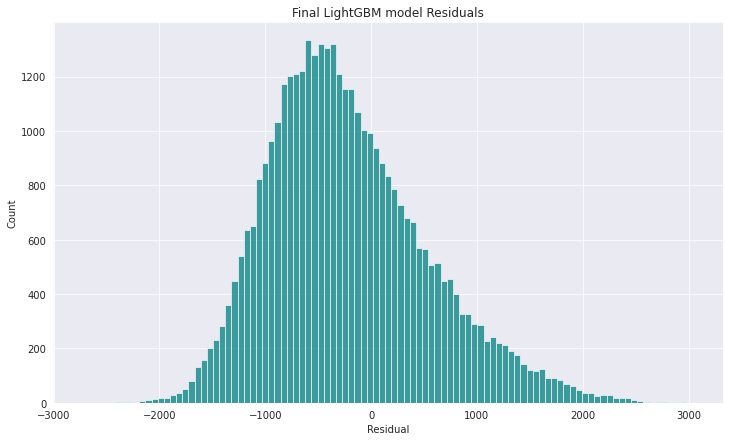

In [ ]:
# Plotting
plt.clf()
sns.set_style('darkgrid')
sns.set_palette('pastel')
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.histplot(x='Final LightGBM', legend=True, color='teal',data=final_residuals_df)
ax.set(title='Final LightGBM model Residuals', xlabel='Residual')

### Feature importances

A final but nonetheless key step in any machine learning project is explaining and justifying your predictions. Models such as neural networks and even gradient boosted trees such as our final LightGBM model, have gained a reputation as unexplainable 'black-box' models. While they do sacrifice some explainability (in comparison with, say, a simple linear regression) in exchange for state-of-the-art performance, this does not mean that they are completely opaque.  

LightGBM provides an out-of-the-box feature importance functionality. Its default measure, which was used in our case, is the number of times a given feature is used to split a node. We will use it to determine which of 5 input variables we used for our model was most 'influential' in shaping the boosted decision trees and therefore predictions.

In [ ]:
final_lgbm.feature_importances_

array([1022,  968, 1036,  981, 1193])

In [ ]:
## Retrieving feature importances
final_features = ['subtotal', 'total_busy_drivers', 'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'outstanding_orders_per_driver']
feature_imps = zip(final_features, final_lgbm.feature_importances_.tolist())
feature_imps_df = pd.DataFrame(feature_imps, columns = ['Feature', 'Feature importance'])

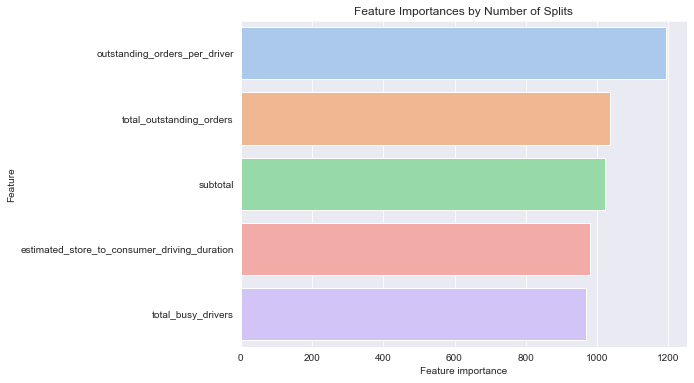

In [50]:
# Plotting feature importances
sns.set_style('darkgrid')
sns.set_palette('pastel')
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(x='Feature importance', y='Feature', \
                     data=feature_imps_df.sort_values(by='Feature importance', ascending=False))
_ = ax.set(title='Feature Importances by Number of Splits', xlabel='Feature importance', \
                ylabel='Feature')

# Conclusion and Final Thoughts

In this project, we attempted a seemingly simple regression task - predicting food delivery ETAs for a third-party delivery company. In doing so, we found several layers of added complexity due to the business objective of minimizing underpredictions in comparison to underpredictions. Our model choices were thus narrowed down to two libraries/algorithms that allowed us to easily implement an asymmetric loss function in order to "skew" our model more on the side of overpredicting during training.  

We compared a simple neural network using Keras with the LightGBM algorithm and found that the latter displayed better performance. Additionally, we compared its predictions using our asymmetric loss function and the default symmetric one, to find that, indeed, we successfully minimized the amount of positive residuals (late orders) while keeping our model robust to tail events. Moreover, LightGBM measured our engineered variable, *outstanding_orders_per_driver* as the most important by number of splits.  

In concrete terms, our model's average error term was under 13 minutes - meaning it can be used to create a delivery window estimate close to 10 minutes. More importantly, our model underpredicted delivery times on only 1/3 of orders, and only 1/4 of all deliveries were more than 3 minutes late.  When interpreting these numbers, it is important to consider the vast multitude of factors that can disrupt a single order and lead to a tail event or even an outlier delivery time. Such factors can affect either the restaurant, the driver, the city itself, or the demand side. With this in mind, narrowing down delivery ETAs to close to a 10 minute window while being able to optimize for other key constraints (i.e. the asymmetric cost function) is an extremely encouraging result.